<a href="https://colab.research.google.com/github/lucasef27/traffic-sign-classification/blob/main/Classifica%C3%A7%C3%A3o_de_sinais_de_transito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
#baixar repositorio do servidor
!wget -O transito.zip "https://upfluxpm-my.sharepoint.com/:u:/g/personal/cleitonsg_upflux_net/ERPVPgf2ewtEk582xMT0jKoBoZAzfJAWduJB9-PS-IzYWw?e=iicQQx&download=1"
!unzip transito.zip

--2023-06-22 21:28:56--  https://upfluxpm-my.sharepoint.com/:u:/g/personal/cleitonsg_upflux_net/ERPVPgf2ewtEk582xMT0jKoBoZAzfJAWduJB9-PS-IzYWw?e=iicQQx&download=1
Resolving upfluxpm-my.sharepoint.com (upfluxpm-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to upfluxpm-my.sharepoint.com (upfluxpm-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/cleitonsg_upflux_net/Documents/ML%20files/transito.zip?ga=1 [following]
--2023-06-22 21:28:58--  https://upfluxpm-my.sharepoint.com/personal/cleitonsg_upflux_net/Documents/ML%20files/transito.zip?ga=1
Reusing existing connection to upfluxpm-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 123525080 (118M) [application/x-zip-compressed]
Saving to: ‘transito.zip’

transito.zip        100%[===================>] 117.80M  17.6MB/s    in 11s     

2023-06-22 21:29:10 (11.1 MB/s) - ‘transito.zip’ saved [123525080/123525

In [ ]:
with open("train.p", mode='rb') as traind:
  train = pickle.load(traind)
with open("valid.p", mode='rb') as vd:
  valid = pickle.load(vd)
with open("test.p", mode='rb') as testd:
  test = pickle.load(testd)

X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print(X_train.shape)
print(y_train.shape)

(34799, 32, 32, 3)
(34799,)


In [ ]:
test['labels']

array([16,  1, 38, ...,  6,  7, 10], dtype=uint8)

In [ ]:
print("Número de exemplos para treinamento =", len(X_train))
print("Número de exemplos para validação =", len(X_validation))
print("Número de exemplos para teste =", len(X_test))
print("Formato de imagens =", X_train[0].shape)

unique_classes, n_samples = np.unique(y_train, return_index=False, return_inverse=False, return_counts=True)

n_classes = len(unique_classes)
print("Nº de classes =", n_classes)

Número de exemplos para treinamento = 34799
Número de exemplos para validação = 4410
Número de exemplos para teste = 12630
Formato de imagens = (32, 32, 3)
Nº de classes = 43


In [ ]:
labels = pd.read_csv('signnames.csv') # ler apenas os nomes
print(labels)
label_signs = labels.values[:,1]

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

Passo 2: exploração dataset

34
Turn left ahead


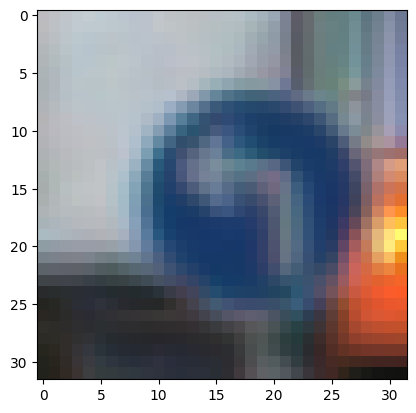

In [ ]:
i = 2000 # i = random.randint(1,12630) >>> antes import random
plt.imshow(X_test[i])
print(y_test[i])
print(label_signs[y_test[i]])

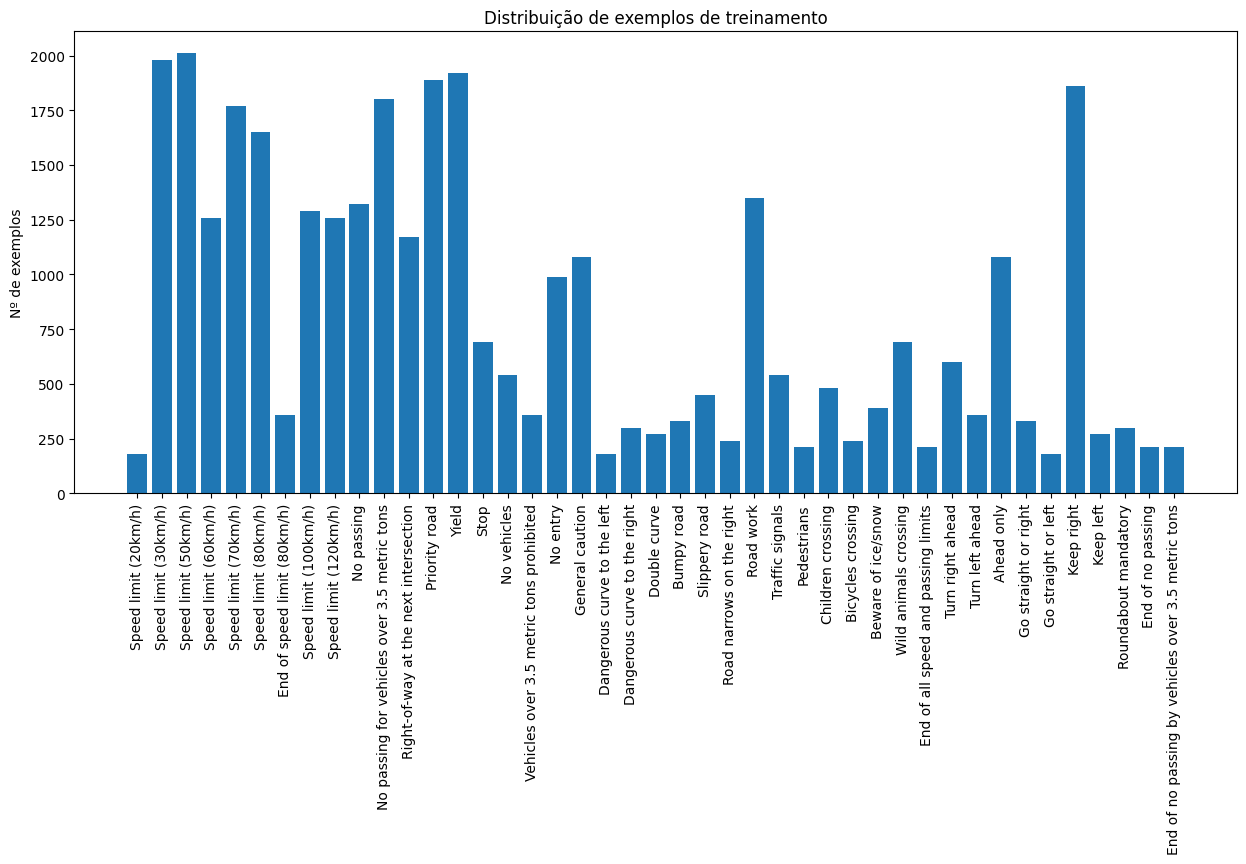

In [ ]:
labels_unique = []
for i in range(n_classes):
  labels_unique.append(label_signs[i])

index = random.randint(0, len(X_train))

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
ax.set_title("Distribuição de exemplos de treinamento")
ax.set_xticks(np.arange(len(labels_unique)))
ax.set_xticklabels(labels_unique, rotation='vertical')
ax.set_ylabel('Nº de exemplos')
plt.bar(range(n_classes), n_samples)
plt.show()

Etapa 3: preparação de dados

In [ ]:
# embaralhar
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)
X_test_gray = np.sum(X_test/3, axis=3, keepdims=True)
X_validation_gray = np.sum(X_validation/3, axis=3, keepdims=True)

#normalizar: o valor de cada pixel ficará entre -1 .. 1

X_train_gray_norm = (X_train_gray - 128)/128
X_test_gray_norm = (X_test_gray - 128)/128
X_validation_gray_norm = (X_validation_gray -128)/128

X_train_gray.shape

(34799, 32, 32, 1)

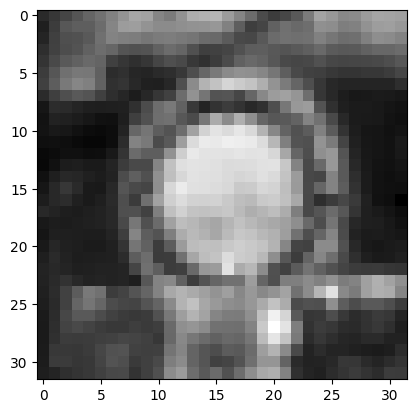

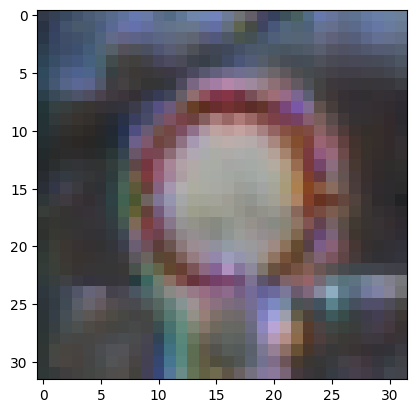

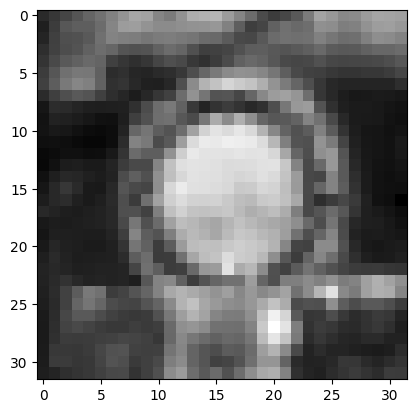

In [ ]:
i = 610
#função squeeze() é usada quando queremos remover entradas unidimensionais da
#forma de umarray ao invés de shape 32 x 32 x 1 ficou 32 x 32

plt.imshow(X_train_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_train[i]) # 32 x 32 x 3
plt.figure()
plt.imshow(X_train_gray_norm[i].squeeze(), cmap='gray')

Etapa 4: Treinamento de modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard

In [ ]:
print(X_train_gray[i].shape)
# este será o input shape

cnn_model = Sequential()
# entrada da imagem em escala de cinza 32x32x1 (pré-processada)
# Camada 1 - Convolution 5x5 > preenchimento válido, formato de saída 28x28x6 com função
cnn_model.add(Conv2D(filters=6, kernel_size=(5,5), activation='relu', input_shape=(32,32,1)))

# Reduz (max pooling) a resolução da entrada ao longo de suas dimensões especiais (altura)
cnn_model.add(AveragePooling2D())

#Layer 2 = Convolution 5x5, saída 10x10x16
cnn_model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu'))
#Reduz 5x5x16
cnn_model.add(AveragePooling2D())

#Layer 3 - COnvolution 5x5x16 para saída 1x1x400
cnn_model.add(Flatten())

# Layer 4 - Totalmente conectada com 400 entradas e 120 saídas
cnn_model.add(Dense(120, activation='relu'))

# Layer 5 - Totalmente conectada com 400 entradas e 120 saídas
cnn_model.add(Dense(84, activation='relu'))

# Layer 6 - Totalmente conectada com 400 entradas e 120 saídas
cnn_model.add(Dense(43, activation='softmax'))

cnn_model.compile(loss = 'sparse_categorical_crossentropy', optimzer='Adam', metrics = ('accurancy'))


history = cnn_model.fit(X_train_gray_norm, y_train, batch_size=500, epochs=50, verbose=1, validation_data = (X_train_gray_norm, y_validation))

(32, 32, 1)


TypeError: ignored

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accurancy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Trainamento accuracy')
plt.plot(epochs, val_accuracy, 'b', label='validações Accuracy')
plt.title('Acuracia sobre treinamento x validação')
plt.legend()
plt.show()

Passo 5: Avaliação do modelo

In [ ]:
score = cnn_model.evaluate(X_test_gray_norm, y_test, verbose=0)
print('Avaliação da acurácia : {:.4}'.format(score[1]))

Passo 6: Testes

In [ ]:
# Predição sobre a base de testes the predictions for the test data

predict_y = cnn_model.predict(X_test_gray_norm)
predited_classes = np.argmax(predict_y, axis=1)

#obter os indices a serem plotados
y_true = y_test
